# A simplified empirical model to estimate oxygen relaxivity at different magnetic field strengths

Emma Bluemke, Eleanor Stride, Daniel Bulte

Institute of Biomedical Engineering, Department of Engineering Sciences, University of Oxford, UK

emma.bluemke@new.ox.ac.uk

### Abstract
Researchers have investigated using the paramagnetic relaxivity effect of oxygen on longitudinal relaxation as a means of inferring oxygenation levels for applications ranging from cancer therapy to seawater analysis. The relationship between PO2 and R1 is linear and reproducible, and the constant of proportionality represents the relaxivity of oxygen, or r1Ox, in that material. However, there is considerable variability in the values of r1Ox reported, and they have been shown to vary by field strength and temperature. Therefore, we have compiled 28 reported empirical values of the relaxivity of oxygen as a resource for researchers. Furthermore, we provide an empirical model for estimating the relaxivity of oxygen in water, saline, plasma and vitreous fluids, accounting for magnetic field strength and temperature. The model agrees well (R2=0.93) with the data gathered from literature, ranging from 0.011-8.45T and 21-40°C. This provides a useful resource for researchers seeking to quantify PO2 in simple fluids in their studies, such as water and saline phantoms, or bodily fluids such as vitreous fluids, cerebrospinal fluids, and amniotic fluids.

### About this notebook
The relaxivity values collected were from experiments performed over a timespan of five decades with a huge variation in experimental equipment and temperature measurement techniques. In addition, the values have often been extracted from original plots, some hand-drawn, which is a source of error, and converted from the various original units to s-1/mmHg, which can be another source of error. Experimental measurement of r1Ox can be difficult even within a relatively simple system such as water because the measurement accuracy depends on the proper selection of acquisition protocols and parameters (i.e. repetition and inversion times).

These limitations are a large source of potential error in the accuracy of this model, which could be solved by the NMR community producing new, modern measurements of r1Ox at a range of field strengths and temperatures. As a future direction of this work, we have hosted the open-source model code and current r1Ox measurements on GitHub and invite the NMR community to share new r1Ox measurement results and re-fit the model to improve accuracy. Such a project would greatly improve this model. 

In particular, we welcome future researchers to perform measurements in plasma or vitreous fluids at different field strengths and temperatures and re-fit this model. 

## Imports

In [4]:
import numpy as np
import math
import random
from scipy.optimize import least_squares
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
# Apply the default theme
plt.style.use('seaborn-white')
from sklearn.model_selection import train_test_split
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn
from sklearn.metrics import mean_squared_error

## Creating Figure 1
Figure 1: The relationship between (A) T1 vs PO2 and (B) R1 vs PO2 in a solution, with the initial T1 of 3000ms. The values are calculated using a range of r1Ox (relaxivity) reported in the literature at 1.5T, in units s-1/mmHg oxygen. 

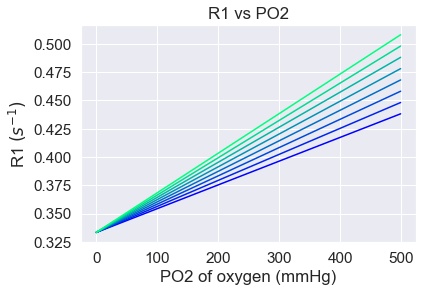

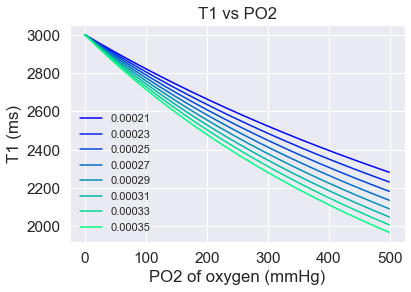

In [5]:
T1_0=3000 # T1 in ms
R1_0=(1/T1_0)*1000 # R1 in s^-1
C=np.arange(0,500) # mmHg

sns.set(font_scale=1.4)
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
    
for x in [21,23,25,27,29,31,33,35]:
    r1=x/100000 #s-1/mmHg - from 2016 Muir Table 1 - water 1.5T Zaharchuk 2006
    R1_after=R1_0+(r1*C)
    T1_after=(1/R1_after)*1000
    
    plt.plot(C,R1_after,label=str(r1))
    plt.title('R1 vs PO2')
    plt.xlabel('PO2 of oxygen (mmHg)')
    plt.ylabel('R1 $(s^{-1})$')
colormap = plt.cm.winter #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0, 1,len(ax1.lines))]
for i,j in enumerate(ax1.lines):
    j.set_color(colors[i])
sns.set(font_scale=1)



sns.set(font_scale=1.4)
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
for x in [21,23,25,27,29,31,33,35]:
    r1=x/100000 #s-1/mmHg - from 2016 Muir Table 1 - water 1.5T Zaharchuk 2006
    R1_after=R1_0+(r1*C)
    T1_after=(1/R1_after)*1000
    
    plt.plot(C,T1_after,label=str(r1))
    plt.title('T1 vs PO2')
    plt.xlabel('PO2 of oxygen (mmHg)')
    plt.ylabel('T1 (ms)')

    colormap = plt.cm.winter #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0, 1,len(ax2.lines))]
for i,j in enumerate(ax2.lines):
    j.set_color(colors[i])

sns.set(font_scale=1)
plt.legend()

## Creating Figure 2
Figure 2: The relationship between (A) ΔT1 vs Initial T1 and (B) ΔR1 vs Initial R1, for a ΔPO2 of 200 mmHg. The values are calculated using a range of r1Ox (relaxivity) reported in the literature at 1.5T, in units s-1/mmHg oxygen. 

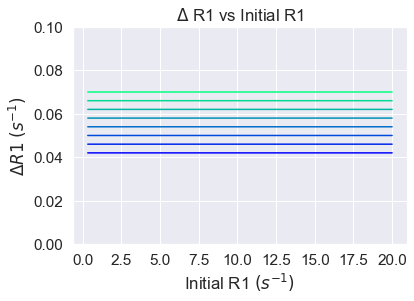

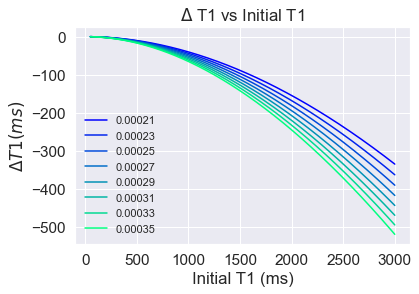

In [6]:
T1_0=np.arange(50,3000) # T1 in ms
R1_0=(1/T1_0)*1000 # R1 in s^-1
r1_water=0.00025 #s-1/mmHg - from 2016 Muir Table 1 - water 1.5T Zaharchuk 2006
C=200 # mmHg
R1_after=R1_0+(r1_water*C)
T1_after=(1/R1_after)*1000

delta_R1_example=R1_after-R1_0
delta_T1_example=T1_after-T1_0

sns.set(font_scale=1.4)
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)


for x in [21,23,25,27,29,31,33,35]:
    r1=x/100000 #s-1/mmHg - from 2016 Muir Table 1 - water 1.5T Zaharchuk 2006
    R1_after=R1_0+(r1*C)
    delta_R1_example=R1_after-R1_0
    
    plt.plot(R1_0,delta_R1_example,label=str(r1))
    plt.ylim(0,0.1)
    plt.title('$\Delta$ R1 vs Initial R1')
    plt.xlabel('Initial R1 $(s^{-1})$')
    plt.ylabel('$\Delta R1$ $(s^{-1})$')
    
colormap = plt.cm.winter #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0, 1,len(ax1.lines))]
for i,j in enumerate(ax1.lines):
    j.set_color(colors[i])
sns.set(font_scale=1.4)


fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
sns.set(font_scale=1.4)
for x in [21,23,25,27,29,31,33,35]:
    r1=x/100000 #s-1/mmHg - from 2016 Muir Table 1 - water 1.5T Zaharchuk 2006
    R1_after=R1_0+(r1*C)
    delta_R1_example=R1_after-R1_0
    T1_after=(1/R1_after)*1000
    delta_T1_example=T1_after-T1_0
    
    plt.plot(T1_0,delta_T1_example,label=str(r1))
    plt.title('$\Delta$ T1 vs Initial T1')
    plt.xlabel('Initial T1 (ms)')
    plt.ylabel('$\Delta T1 (ms)$')

colormap = plt.cm.winter #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0, 1,len(ax2.lines))]
for i,j in enumerate(ax2.lines):
    j.set_color(colors[i])
sns.set(font_scale=1)
plt.legend()


## Model fitting
You can also set boundaries based on the parameters found in the paper, i.e. add the line:

bounds_list=([2.0,0.0,0.0,0.0],[8.0,4.0,3.0,1.0])

and use:

O2_relaxivity_model = least_squares(O2_relaxivity, x0, args=(y,B0,temp),bounds=bounds_list)


In [3]:
all_data = pd.read_csv('Table1data.csv')

nrepetitions=1000
nsamples=math.floor(len(all_data)*0.90)
ntest=len(all_data)-nsamples


list_of_C1=np.zeros(nrepetitions)
list_of_C2=np.zeros(nrepetitions)
list_of_C3=np.zeros(nrepetitions)
list_of_C4=np.zeros(nrepetitions)
list_of_TempC=np.zeros(nrepetitions)
list_of_y_guess_r1=np.zeros((nrepetitions,ntest))
list_of_y_test_r1=np.zeros((nrepetitions,ntest))
list_of_B0_test_r1=np.zeros((nrepetitions,ntest))
list_of_temp_test_r1=np.zeros((nrepetitions,ntest))



B0_alldata_r1=all_data.B0
y_alldata_r1=all_data.r1
temp_alldata_r1=all_data.Temp


for i in range(0,nrepetitions):
    B0,B0_test,y,y_test,temp,temp_test = train_test_split(B0_alldata_r1,y_alldata_r1,temp_alldata_r1, test_size=0.10)

    def O2_relaxivity(x,y,B0,temp):

        return x[0]/(1+((x[1])*(B0**2))) +x[2] +x[3]*temp -y

    x0 = np.array([5.0,2.0,1.0,0.5])
    O2_relaxivity_model = least_squares(O2_relaxivity, x0, args=(y,B0,temp))

    y_guess=O2_relaxivity_model.x[0]/(1+((O2_relaxivity_model.x[1])*(B0_test**2))) +O2_relaxivity_model.x[2] +O2_relaxivity_model.x[3]*temp_test


    list_of_y_test_r1[i]=y_test
    list_of_y_guess_r1[i]=y_guess
    list_of_B0_test_r1[i]=B0_test
    list_of_temp_test_r1[i]=temp_test
    
    list_of_C1[i] =O2_relaxivity_model.x[0]
    list_of_C2[i] =O2_relaxivity_model.x[1]
    list_of_C3[i] =O2_relaxivity_model.x[2]
    list_of_TempC[i] =O2_relaxivity_model.x[3]


## Print the median parameter values and 95% confidence intervals

In [7]:
C1_median=np.median(list_of_C1)
C2_median=np.median(list_of_C2)
C3_median=np.median(list_of_C3)
TempC_median=np.median(list_of_TempC)



C1_std=np.std(list_of_C1)
C2_std=np.std(list_of_C2)
C3_std=np.std(list_of_C3)
TempC_std=np.std(list_of_TempC)


lowerCI_C1 = C1_median - 1.96*C1_std
upperCI_C1 = C1_median + 1.96*C1_std

lowerCI_C2 = C2_median - 1.96*C2_std
upperCI_C2 = C2_median + 1.96*C2_std

lowerCI_C3 = C3_median - 1.96*C3_std
upperCI_C3 = C3_median + 1.96*C3_std

lowerCI_TempC = TempC_median - 1.96*TempC_std
upperCI_TempC = TempC_median + 1.96*TempC_std



print('C1 median =',C1_median)
print('C1 lower CI =',lowerCI_C1)
print('C1 upper CI =',upperCI_C1)

print('C2 median =',C2_median)
print('C2 lower CI =',lowerCI_C2)
print('C2 upper CI =',upperCI_C2)

print('C3 median =',C3_median)
print('C3 lower CI =',lowerCI_C3)
print('C3 upper CI =',upperCI_C3)

print('CTemp median =',TempC_median)
print('CTemp lower CI =',lowerCI_TempC)
print('CTemp upper CI =',upperCI_TempC)


C1 median = 4.868336635561287
C1 lower CI = 4.700694135370706
C1 upper CI = 5.035979135751869
C2 median = 2.005496956072406
C2 lower CI = 1.6038996856282648
C2 upper CI = 2.4070942265165476
C3 median = 0.842289057968092
C3 lower CI = 0.43919506775056105
C3 upper CI = 1.245383048185623
CTemp median = 0.03231252686721643
CTemp lower CI = 0.02069301621029314
CTemp upper CI = 0.043932037524139725


## Display the violin plots of estimates for each parameter (Supplementary Figure S1)
Supplementary Figure S1: (A) Violin plots showing the distribution of parameter estimates from each iteration. Y axis units per parameter: C1 [x10-4  s−1/mmHg], C2 [T−2], C3 [x10-4  s−1/mmHg], and CTemp [x10-4 s−1/mmHg /°C]. (B) CTemp displayed separately for better visualization of the distribution.

Text(0.5, 1.0, 'Parameter Estimations')

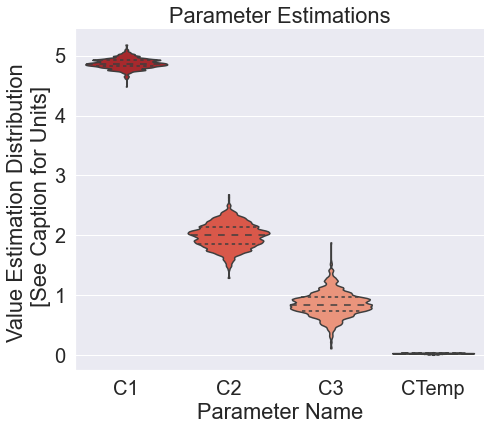

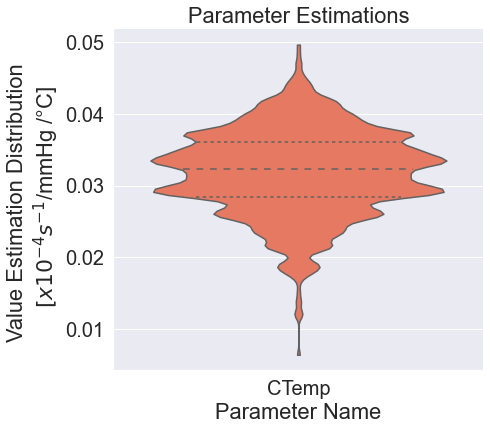

In [17]:
all_variables_o=np.array([list_of_C1,list_of_C2,list_of_C3,list_of_TempC])
all_variables=all_variables_o.T
np.shape(all_variables)

all_variables_df = pd.DataFrame(all_variables, columns = ['C1','C2','C3','CTemp'])
sns.set(font_scale=1.82)
g = sns.catplot(data=all_variables_df,kind='violin',cut=0,bw=0.1,scale='width',palette='Reds_r',inner="quartile");
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(7, 6)
plt.ylabel('Value Estimation Distribution \n [See Caption for Units]')
plt.xlabel('Parameter Name')
plt.title('Parameter Estimations')

all_variables_o=np.array([list_of_TempC])
all_variables=all_variables_o.T
np.shape(all_variables)

all_variables_df = pd.DataFrame(all_variables, columns = ['CTemp'])
sns.set(font_scale=1.82)
g = sns.catplot(data=all_variables_df,kind='violin',cut=0,bw=0.1,scale='width',palette='Reds_r',inner="quartile");
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(7, 6)
plt.ylabel('Value Estimation Distribution \n $[x10^{-4} s^{−1}$/mmHg /°C]')
plt.xlabel('Parameter Name')
plt.title('Parameter Estimations')

## Create Supplementary Figure S2
Supplementary Figure S2: (A) The modelled vs measured r1Ox values from the randomized unseen test set of each iteration, plotted against the line of equality (solid black line) and a linear regression (red dotted line, R2=0.91). (B) A Bland-Altman plot showing the difference between the modelled and measured values of r1Ox. The horizontal long-dashed lines show the mean value of Δr1Ox (-0.005 s-1x10-4/mmHg), and the horizontal dotted lines show the limits of agreement (long dashes, calculated by mean(Δr1Ox) ± (1.96xSD(Δr1Ox)). Bland-Altman plots for the error in modelled r1Ox against (C) temperature, and (D) field strength are also shown to examine bias in the model.

Estimate vs True R2= 0.8993036375855412
MSE is 0.2753685520193964


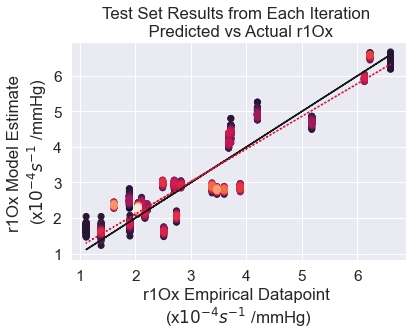

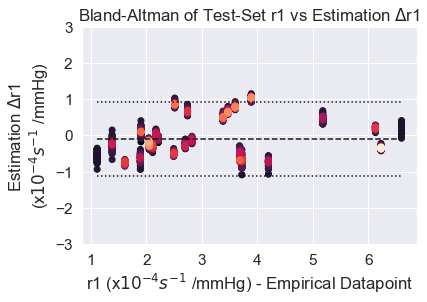

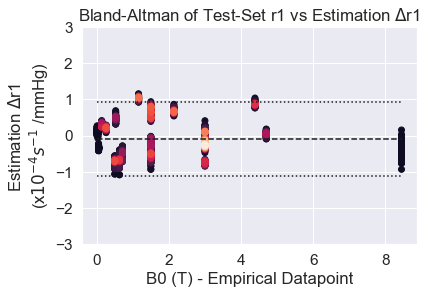

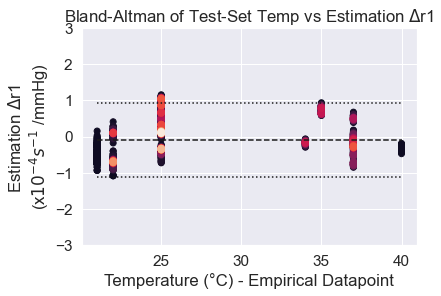

In [10]:
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn

def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter( x, y, c=z, **kwargs )

    norm = Normalize(vmin = np.min(z), vmax = np.max(z))
    return ax



flat_list_of_y_test_r1=list_of_y_test_r1.flatten()
flat_list_of_y_guess_r1=list_of_y_guess_r1.flatten()
flat_list_of_B0_test_r1=list_of_B0_test_r1.flatten()
flat_list_of_temp_test_r1=list_of_temp_test_r1.flatten()

y_error_r1=flat_list_of_y_test_r1-flat_list_of_y_guess_r1
median_r1error=np.median(y_error_r1)
std_r1error=np.std(y_error_r1)

crude_lower_limit_r1 = median_r1error-1.96*std_r1error
crude_upper_limit_r1 = median_r1error+ 1.96*std_r1error


sns.set(font_scale=1)

flat_list_of_y_test_r1_reshape=flat_list_of_y_test_r1.reshape(-1, 1)
flat_list_of_y_guess_r1_reshape=list_of_y_guess_r1.reshape(-1, 1)



sns.set(font_scale=1.4)

reg_v_true_final = LinearRegression().fit(flat_list_of_y_test_r1_reshape,flat_list_of_y_guess_r1_reshape)
print('Estimate vs True R2=',reg_v_true_final.score(flat_list_of_y_test_r1_reshape,flat_list_of_y_guess_r1_reshape))
meanSE=mean_squared_error(flat_list_of_y_test_r1_reshape,flat_list_of_y_guess_r1_reshape)
print('MSE is', meanSE)
density_scatter(flat_list_of_y_test_r1, flat_list_of_y_guess_r1, bins = [50,50] )
plt.plot(flat_list_of_y_test_r1,flat_list_of_y_test_r1,'k')
plt.plot(flat_list_of_y_test_r1_reshape,np.squeeze(reg_v_true_final.predict(flat_list_of_y_test_r1_reshape)),'k',linestyle='dotted',color='crimson')
plt.xlabel('r1Ox Empirical Datapoint \n(x$10^{-4} s^{-1}$ /mmHg)')
plt.ylabel('r1Ox Model Estimate \n(x$10^{-4} s^{-1}$ /mmHg)')
plt.title('Test Set Results from Each Iteration \n Predicted vs Actual r1Ox')


density_scatter(flat_list_of_y_test_r1,y_error_r1,bins = [50,50])
plt.hlines(median_r1error,np.min(flat_list_of_y_test_r1),np.max(flat_list_of_y_test_r1),linestyle='dashed')
plt.hlines(crude_lower_limit_r1,np.min(flat_list_of_y_test_r1),np.max(flat_list_of_y_test_r1),linestyle='dotted')
plt.hlines(crude_upper_limit_r1,np.min(flat_list_of_y_test_r1),np.max(flat_list_of_y_test_r1),linestyle='dotted')
plt.ylim(-3,3)
plt.xlabel('r1 (x$10^{-4} s^{-1}$ /mmHg) - Empirical Datapoint')
plt.ylabel('Estimation $\Delta$r1 \n(x$10^{-4} s^{-1}$ /mmHg)')
plt.title('Bland-Altman of Test-Set r1 vs Estimation $\Delta$r1')
plt.show()

density_scatter(flat_list_of_B0_test_r1,y_error_r1,bins = [50,50])
plt.hlines(median_r1error,np.min(flat_list_of_B0_test_r1),np.max(flat_list_of_B0_test_r1),linestyle='dashed')
plt.hlines(crude_lower_limit_r1,np.min(flat_list_of_B0_test_r1),np.max(flat_list_of_B0_test_r1),linestyle='dotted')
plt.hlines(crude_upper_limit_r1,np.min(flat_list_of_B0_test_r1),np.max(flat_list_of_B0_test_r1),linestyle='dotted')
plt.ylim(-3,3)
plt.xlabel('B0 (T) - Empirical Datapoint')
plt.ylabel('Estimation $\Delta$r1 \n(x$10^{-4} s^{-1}$ /mmHg)')
plt.title('Bland-Altman of Test-Set r1 vs Estimation $\Delta$r1')
plt.show()


density_scatter(flat_list_of_temp_test_r1,y_error_r1,bins = [50,50])
plt.hlines(median_r1error,np.min(flat_list_of_temp_test_r1),np.max(flat_list_of_temp_test_r1),linestyle='dashed')
plt.hlines(crude_lower_limit_r1,np.min(flat_list_of_temp_test_r1),np.max(flat_list_of_temp_test_r1),linestyle='dotted')
plt.hlines(crude_upper_limit_r1,np.min(flat_list_of_temp_test_r1),np.max(flat_list_of_temp_test_r1),linestyle='dotted')
plt.ylim(-3,3)
plt.xlabel('Temperature (°C) - Empirical Datapoint')
plt.ylabel('Estimation $\Delta$r1 \n(x$10^{-4} s^{-1}$ /mmHg)')
plt.title('Bland-Altman of Test-Set Temp vs Estimation $\Delta$r1')
plt.show()


## Create Figure 3
Figure 3: (A) The modelled vs measured r1Ox values, plotted against the line of equality (solid black line) and a linear regression (red dotted line, R2=0.93). (B) A Bland-Altman plot showing the difference between the modelled and measured values of r1Ox. The horizontal long-dashed lines show the mean value of Δr1Ox (-0.005 s-1x10-4/mmHg), and the horizontal dotted lines show the limits of agreement (long dashes, calculated by mean(Δr1Ox) ± (1.96xSD(Δr1Ox)). Bland-Altman plots for the error in modelled r1Ox against (C) temperature, and (D) field strength are also shown to examine bias in the model.

MSE is 0.1938474568341371
Estimate vs True R2= 0.9310038535229704


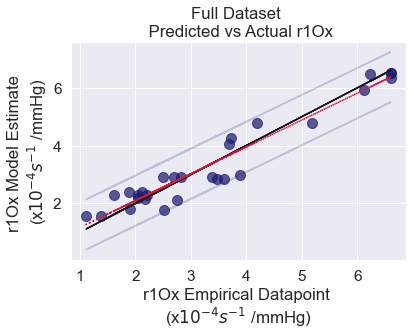

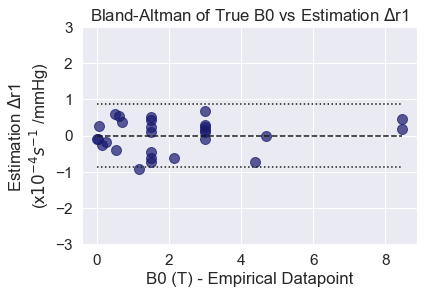

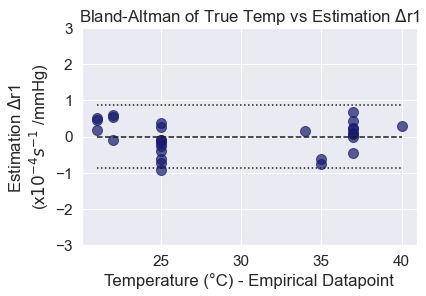

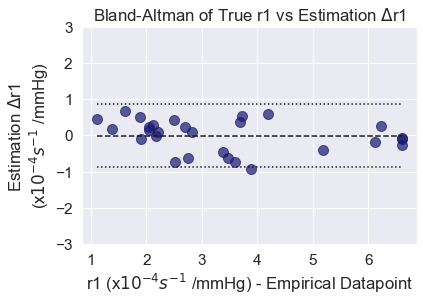

In [14]:

sns.set(font_scale=1.4)

B0_alldata_r1=all_data.B0
y_alldata_r1=all_data.r1

temp_alldata_r1=all_data.Temp

y_pred=C1_median/(1+(C2_median)*(B0_alldata_r1**2)) +C3_median +TempC_median*temp_alldata_r1 
y_true=y_alldata_r1

y_true=y_true
y_pred=y_pred

meanSE=mean_squared_error(y_true, y_pred)
print('MSE is', meanSE)


y_pred=np.asarray(y_pred)
y_true=np.asarray(y_true)

y_pred_reshape=y_pred.reshape(-1, 1)
y_true_reshape=y_true.reshape(-1, 1)

y_error=y_pred-y_true
mean_R1error=np.mean(y_error)
std_error=np.std(y_error)
crude_lower_limit = mean_R1error-1.96*std_error
crude_upper_limit = mean_R1error+ 1.96*std_error

reg_v_true_final = LinearRegression().fit(y_true_reshape,y_pred_reshape)
print('Estimate vs True R2=',reg_v_true_final.score(y_true_reshape,y_pred_reshape))


plt.scatter(y_true,y_pred,s=100,alpha=0.7,color='midnightblue')

plt.plot(y_true,y_true,'k')
plt.plot(y_true,np.squeeze(reg_v_true_final.predict(y_true_reshape)),'k',linestyle='dotted',color='crimson')
plt.plot(y_true,np.squeeze(reg_v_true_final.predict(y_true_reshape)-1.98*std_error),color='midnightblue',alpha=0.2)
plt.plot(y_true,np.squeeze(reg_v_true_final.predict(y_true_reshape)+1.98*std_error),color='midnightblue',alpha=0.2)

plt.xlabel('r1Ox Empirical Datapoint \n(x$10^{-4} s^{-1}$ /mmHg)')
plt.ylabel('r1Ox Model Estimate \n(x$10^{-4} s^{-1}$ /mmHg)')
plt.title('Full Dataset \n Predicted vs Actual r1Ox')

plt.show()

plt.scatter(B0_alldata_r1,y_error,color='midnightblue',s=100,alpha=0.7)
plt.hlines(mean_R1error,np.min(B0_alldata_r1),np.max(B0_alldata_r1),linestyle='dashed')
plt.hlines(crude_lower_limit,np.min(B0_alldata_r1),np.max(B0_alldata_r1),linestyle='dotted')
plt.hlines(crude_upper_limit,np.min(B0_alldata_r1),np.max(B0_alldata_r1),linestyle='dotted')
plt.ylim(-3,3)
plt.xlabel('B0 (T) - Empirical Datapoint')
plt.ylabel('Estimation $\Delta$r1 \n(x$10^{-4} s^{-1}$ /mmHg)')
plt.title('Bland-Altman of True B0 vs Estimation $\Delta$r1')
plt.show()

plt.scatter(temp_alldata_r1,y_error,color='midnightblue',s=100,alpha=0.7)
plt.hlines(mean_R1error,np.min(temp_alldata_r1),np.max(temp_alldata_r1),linestyle='dashed')
plt.hlines(crude_lower_limit,np.min(temp_alldata_r1),np.max(temp_alldata_r1),linestyle='dotted')
plt.hlines(crude_upper_limit,np.min(temp_alldata_r1),np.max(temp_alldata_r1),linestyle='dotted')
plt.ylim(-3,3)
plt.xlabel('Temperature (°C) - Empirical Datapoint')
plt.ylabel('Estimation $\Delta$r1 \n(x$10^{-4} s^{-1}$ /mmHg)')
plt.title('Bland-Altman of True Temp vs Estimation $\Delta$r1')
plt.show()

plt.scatter(y_alldata_r1,y_error,color='midnightblue',s=100,alpha=0.7)
plt.hlines(mean_R1error,np.min(y_alldata_r1),np.max(y_alldata_r1),linestyle='dashed')
plt.hlines(crude_lower_limit,np.min(y_alldata_r1),np.max(y_alldata_r1),linestyle='dotted')
plt.hlines(crude_upper_limit,np.min(y_alldata_r1),np.max(y_alldata_r1),linestyle='dotted')
plt.ylim(-3,3)
plt.xlabel('r1 (x$10^{-4} s^{-1}$ /mmHg) - Empirical Datapoint')
plt.ylabel('Estimation $\Delta$r1 \n(x$10^{-4} s^{-1}$ /mmHg)')
plt.title('Bland-Altman of True r1 vs Estimation $\Delta$r1')
plt.show()



## Create Figure 4
Plots with simulated data to illustrate the behaviour of Equation 5 (with the fit parameter values) with respect to (A) B0 and (B) log(B0) for a variety of temperatures.

Text(0.5, 1.0, 'Simulated r1Ox vs Field Strength \n at Various Temperatures')

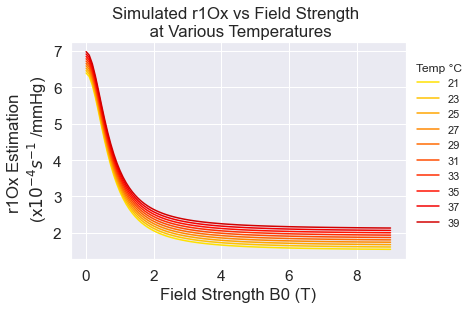

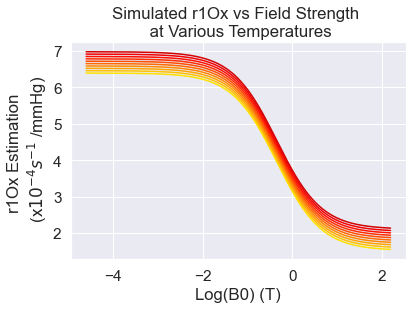

In [85]:
sns.set(font_scale=1.4)
B0_sim=np.linspace(0.01,9,100)
np.shape(B0_sim)
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
for i in [21,23,25,27,29,31,33,35,37,39]:
    Temp_sim=i
    r1_sim=C1_median/(1+((C2_median)*(B0_sim**2))) +C3_median +TempC_median*Temp_sim 
    plt.plot(B0_sim,r1_sim,label=Temp_sim)
colormap = plt.cm.hot_r#nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0.3, 0.7,len(ax2.lines))]
for i,j in enumerate(ax2.lines):
    j.set_color(colors[i])

plt.xlabel('Field Strength B0 (T)')
plt.ylabel('r1Ox Estimation \n (x$10^{-4} s^{-1}$ /mmHg)')
plt.title('Simulated r1Ox vs Field Strength \n at Various Temperatures')
sns.set(font_scale=1)
ax2.legend(bbox_to_anchor=(1, 0.95),title='Temp °C')

sns.set(font_scale=1.4)
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)

B0_sim=np.linspace(0.01,9,1000)
np.shape(B0_sim)
for i in [21,23,25,27,29,31,33,35,37,39]:
    Temp_sim=i
    r1_sim=C1_median/(1+((C2_median)*(B0_sim**2))) +C3_median +TempC_median*Temp_sim 
    plt.plot(np.log(B0_sim),r1_sim,label=Temp_sim)
colormap = plt.cm.hot_r#nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0.3, 0.7,len(ax2.lines))]
for i,j in enumerate(ax2.lines):
    j.set_color(colors[i])


plt.xlabel('Log(B0) (T)')
plt.ylabel('r1Ox Estimation \n (x$10^{-4} s^{-1}$ /mmHg)')
plt.title('Simulated r1Ox vs Field Strength \n at Various Temperatures')


## Create Figure 5
The r1Ox of the 28 literature points, plotted against (A) field strength and (B) log(field strength) alongside the r1Ox estimated using the new model (black dashed line) at the appropriate B0, and 37°C with the 95% confidence interval shown in grey. For this plot only, each literature value has been linearly corrected to 37°C using the CTemp parameter.


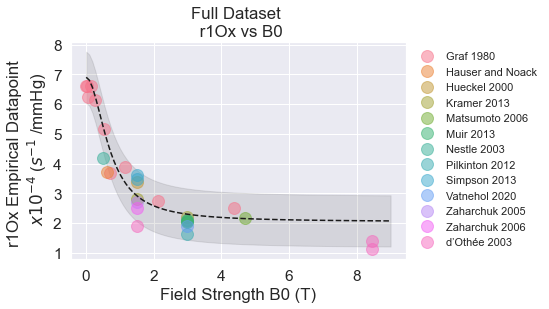

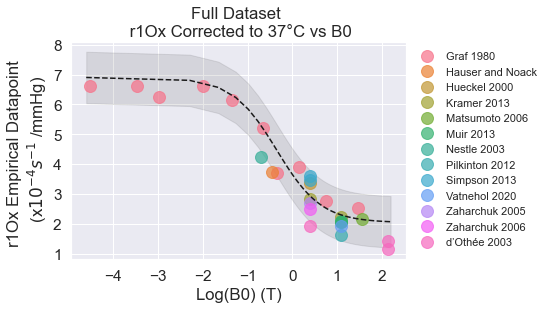

In [16]:
all_data = pd.read_csv('Table1data.csv')
sns.set(font_scale=1.4)
B0_sim=np.linspace(0.01,9,100)
np.shape(B0_sim)
Temp_sim=37
r1_sim=C1_median/(1+((C2_median)*(B0_sim**2))) +C3_median +TempC_median*Temp_sim 
sns.set_palette("husl", 13)
groups = all_data.groupby('Ref')
# Plot

fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.B0, group.r1, marker='o', linestyle='', label=name,markersize=12,alpha=0.5)

plt.xlabel('Field Strength B0 (T)')
plt.ylabel('r1Ox Empirical Datapoint \n $x10^{-4}$ ($s^{-1}$ /mmHg)')
plt.title('Full Dataset \n r1Ox vs B0')
plt.plot(B0_sim,r1_sim,'k',linestyle='--')
plt.fill_between(B0_sim,r1_sim+1.96*std_error,r1_sim-1.96*std_error, color='k',alpha=0.1)

sns.set(font_scale=1)
ax.legend(bbox_to_anchor=(1, 1))

all_data = pd.read_csv('Table1data.csv')
sns.set(font_scale=1.4)
B0_sim=np.linspace(0.01,9,100)
np.shape(B0_sim)
Temp_sim=37
r1_sim=C1_median/(1+((C2_median)*(B0_sim**2))) +C3_median +TempC_median*Temp_sim 
sns.set_palette("husl", 13)
groups = all_data.groupby('Ref')
# Plot


fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(np.log(group.B0), group.r1_tempcorrect, marker='o', linestyle='', label=name,markersize=12,alpha=0.7)

plt.xlabel('Log(B0) (T)')
plt.ylabel('r1Ox Empirical Datapoint \n (x$10^{-4} s^{-1}$ /mmHg)')
plt.title('Full Dataset \n r1Ox Corrected to 37°C vs B0')
plt.plot(np.log(B0_sim),r1_sim,'k',linestyle='--')
plt.fill_between(np.log(B0_sim),r1_sim+1.96*std_error,r1_sim-1.96*std_error, color='k',alpha=0.1)
sns.set(font_scale=1)
ax.legend(bbox_to_anchor=(1, 1))


## Create Supplementary Figure S4
Supplementary Figure S4: A plot with simulated data to illustrate the behaviour of Equation 5 (with the fit parameter values) with respect to temperature and for a variety of magnetic field strengths.

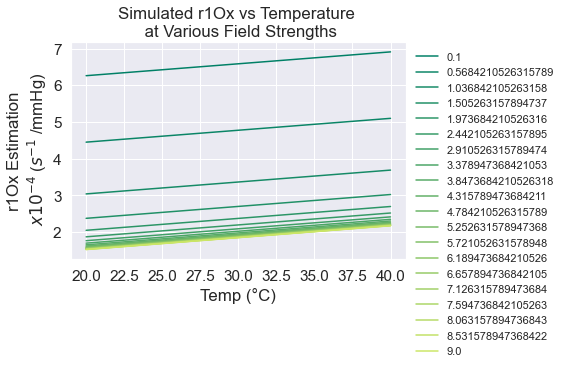

In [59]:

all_data = pd.read_csv('Table1data.csv')
sns.set(font_scale=1.4)
Temp_sim=np.linspace(20,40,10)
np.shape(B0_sim)

fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
for i in np.linspace(0.1,9,20):
    B0_sim=i
    r1_sim=C1_median/(1+((C2_median)*(B0_sim**2))) +C3_median +TempC_median*Temp_sim 
    plt.plot(Temp_sim,r1_sim,'k',label=B0_sim)

colormap = plt.cm.summer #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0, 0.8,len(ax2.lines))]
for i,j in enumerate(ax2.lines):
    j.set_color(colors[i])
plt.xlabel('Temp (°C)')
plt.ylabel('r1Ox Estimation\n $x10^{-4}$ ($s^{-1}$ /mmHg)')
plt.title('Simulated r1Ox vs Temperature \n at Various Field Strengths')

sns.set(font_scale=1)
ax2.legend(bbox_to_anchor=(1, 1))